# Response Surface Methodology (RSM) for Expensive Simulations

## The Physical Problem: Heat Conduction in a Metal Rod

We simulate the **maximum temperature** in a metal rod under different conditions:
- **x1**: Thermal conductivity (W/m·K), range [10, 400]
- **x2**: Heat source intensity (W/m³), range [1000, 10000]
- **x3**: Rod length (m), range [0.1, 1.0]

The "expensive simulation" (e.g., FEM solver) is replaced by a **Response Surface Model** trained on a small set of runs.

## What is Response Surface Methodology?

RSM approximates a complex simulator with a **polynomial regression model** — typically a quadratic (2nd-order) polynomial that captures:
- Linear effects of each variable
- Squared (curvature) effects
- Two-way interaction effects between variables

$$\hat{y} = \beta_0 + \sum_i \beta_i x_i + \sum_i \beta_{ii} x_i^2 + \sum_{i<j} \beta_{ij} x_i x_j + \epsilon$$

**Workflow:**
1. Define the expensive simulation (black-box function)
2. Generate a structured DoE (Central Composite Design)
3. Fit a quadratic Response Surface Model
4. Validate the surrogate vs the true simulator
5. Use the surrogate for fast optimization


In [ ]:
# Install required libraries (run once if needed)
# !pip install scikit-learn scipy numpy matplotlib pyDOE2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print("Libraries loaded successfully!")

Libraries loaded successfully!


## Step 1: Define the Expensive Simulation

This represents a finite-element heat conduction solver.
In practice, each call could take minutes to hours — we want to minimize the number of calls.

**Analytical approximation for 1D steady-state heat conduction:**

$$T_{max} = T_0 + \frac{q \cdot L^2}{8 \cdot k} + 0.05 \cdot \frac{q}{k} \cdot \sin(\pi L)$$

In [2]:
# ============================================================
#  EXPENSIVE SIMULATION  (the "real" solver — call sparingly!)
# ============================================================

call_counter = {"count": 0}

def expensive_heat_simulation(X):
    """
    Simulates maximum temperature in a heated metal rod.

    Parameters
    ----------
    X : array of shape (n, 3)
        Columns: [thermal_conductivity, heat_source, rod_length]

    Returns
    -------
    T_max : array of shape (n,)  — maximum temperature rise (°C)
    """
    X = np.atleast_2d(X)
    call_counter["count"] += X.shape[0]

    k = X[:, 0]   # thermal conductivity  [10, 400] W/m·K
    q = X[:, 1]   # heat source           [1000, 10000] W/m³
    L = X[:, 2]   # rod length            [0.1, 1.0] m

    T0 = 20.0
    T_max = T0 + (q * L**2) / (8 * k) + 0.05 * (q / k) * np.sin(np.pi * L)
    return T_max


# Sanity check
test_input = np.array([[50, 5000, 0.5]])
print(f"Test simulation: k=50, q=5000, L=0.5 → T_max = {expensive_heat_simulation(test_input)[0]:.2f} °C")
print(f"Simulator calls so far: {call_counter['count']}")

Test simulation: k=50, q=5000, L=0.5 → T_max = 28.12 °C
Simulator calls so far: 1


## Step 2: Design of Experiments — Central Composite Design (CCD)

RSM traditionally uses **structured designs** that are specifically built for fitting polynomial surfaces:

- **Factorial points** (±1 coded): cover the corners of the design space
- **Axial (star) points** (±α): extend along each axis for curvature estimation
- **Center points**: repeated center runs for error estimation

We also add **Latin Hypercube** points to improve coverage across the full space.

In [3]:
# ============================================================
#  DESIGN SPACE BOUNDS
# ============================================================
bounds = {
    'thermal_conductivity': (10,   400),
    'heat_source':          (1000, 10000),
    'rod_length':           (0.1,  1.0),
}

lb = np.array([v[0] for v in bounds.values()])
ub = np.array([v[1] for v in bounds.values()])
feature_names = list(bounds.keys())

def coded_to_real(X_coded, lb, ub):
    """Convert coded [-1, 1] values to real-world units."""
    return 0.5 * (X_coded + 1) * (ub - lb) + lb


# ============================================================
#  CENTRAL COMPOSITE DESIGN  (face-centred, alpha=1)
# ============================================================
k = 3        # number of factors
alpha = 1.0  # axial distance (face-centred CCD)

# 1. Full 2^k factorial points
factorial_coded = np.array(
    [[s1, s2, s3] for s1 in [-1, 1] for s2 in [-1, 1] for s3 in [-1, 1]]
)  # 8 points

# 2. Axial (star) points
axial_coded = np.zeros((2 * k, k))
for i in range(k):
    axial_coded[2*i,     i] = -alpha
    axial_coded[2*i + 1, i] =  alpha
# 6 points

# 3. Center points (repeated for variance estimation)
n_center = 6
center_coded = np.zeros((n_center, k))  # 6 points

# 4. Combine CCD
CCD_coded = np.vstack([factorial_coded, axial_coded, center_coded])  # 20 points
X_train   = coded_to_real(CCD_coded, lb, ub)
y_train   = expensive_heat_simulation(X_train)

print(f"CCD design points:")
print(f"  Factorial points : {len(factorial_coded)}")
print(f"  Axial points     : {len(axial_coded)}")
print(f"  Center points    : {n_center}")
print(f"  Total            : {len(X_train)}")
print(f"\nSimulator calls for training: {call_counter['count']}")
print(f"T_max range: [{y_train.min():.1f}, {y_train.max():.1f}] °C")

CCD design points:
  Factorial points : 8
  Axial points     : 6
  Center points    : 6
  Total            : 20

Simulator calls for training: 21
T_max range: [20.0, 145.0] °C


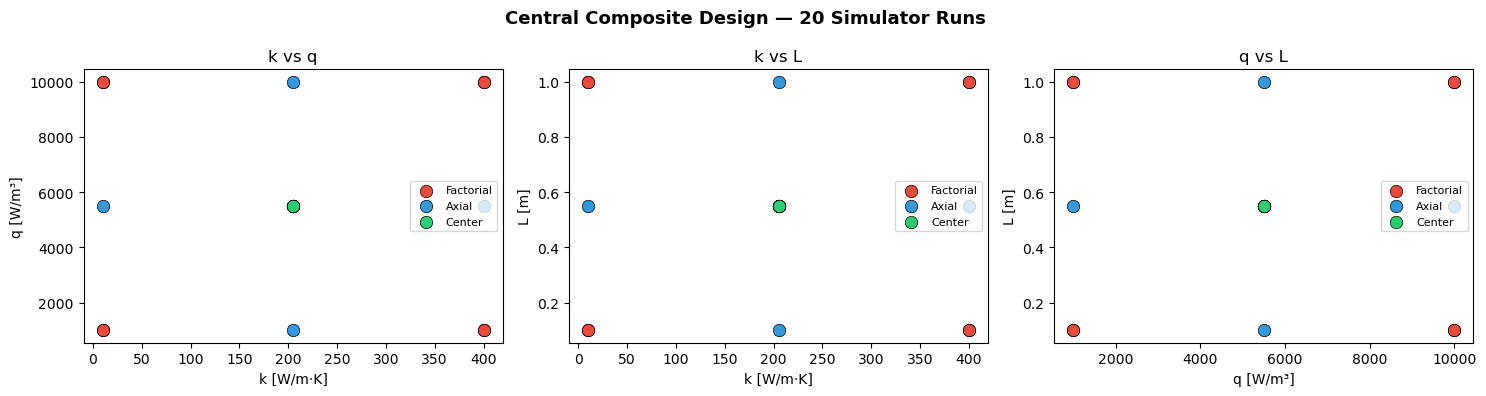

In [4]:
# Visualize the CCD training points
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
labels    = ['Factorial', 'Axial', 'Center']
colors    = ['#e74c3c', '#3498db', '#2ecc71']
n_splits  = [8, 6, 6]
idx       = np.split(np.arange(len(X_train)), [8, 14])

pairs = [(0, 1), (0, 2), (1, 2)]
axis_labels = ['k [W/m·K]', 'q [W/m³]', 'L [m]']

for ax, (i, j) in zip(axes, pairs):
    for group_idx, label, color in zip(idx, labels, colors):
        ax.scatter(X_train[group_idx, i], X_train[group_idx, j],
                   label=label, color=color, s=80, edgecolors='k', linewidths=0.5)
    ax.set_xlabel(axis_labels[i])
    ax.set_ylabel(axis_labels[j])
    ax.set_title(f'{axis_labels[i].split(" ")[0]} vs {axis_labels[j].split(" ")[0]}')
    ax.legend(fontsize=8)

plt.suptitle('Central Composite Design — 20 Simulator Runs', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 3: Fit the Response Surface Model

We fit a **full quadratic polynomial** (2nd-order RSM) using ordinary least squares:

$$\hat{T}_{max} = \beta_0 + \beta_1 k + \beta_2 q + \beta_3 L + \beta_{11} k^2 + \beta_{22} q^2 + \beta_{33} L^2 + \beta_{12} kq + \beta_{13} kL + \beta_{23} qL$$

This gives **10 coefficients** for 3 input variables — well-determined by our 20 CCD points.

In [5]:
# ============================================================
#  FIT THE RESPONSE SURFACE MODEL  (2nd-order polynomial)
# ============================================================

rsm = Pipeline([
    ('scaler', StandardScaler()),
    ('poly',   PolynomialFeatures(degree=2, include_bias=True)),
    ('reg',    LinearRegression())
])

rsm.fit(X_train, y_train)

# Extract and display coefficients
scaler   = rsm.named_steps['scaler']
poly     = rsm.named_steps['poly']
reg      = rsm.named_steps['reg']

coef_names = poly.get_feature_names_out(['k', 'q', 'L'])
coefs      = np.concatenate([[reg.intercept_], reg.coef_[1:]])  # skip poly bias duplicate

print("✅ Response Surface Model trained!")
print(f"   Polynomial degree : 2")
print(f"   Number of terms   : {len(poly.get_feature_names_out())}")
print()
print(f"{'Term':<12} {'Coefficient':>14}")
print("-" * 28)
for name, c in zip(coef_names, np.concatenate([[reg.intercept_], reg.coef_[1:]])):
    print(f"{name:<12} {c:>14.4f}")

✅ Response Surface Model trained!
   Polynomial degree : 2
   Number of terms   : 10

Term            Coefficient
----------------------------
1                   22.9458
k                  -14.0526
q                    9.5139
L                    8.8397
k^2                 10.3616
k q                 -7.7714
k L                 -7.2594
q^2                 -0.7580
q L                  6.2441
L^2                 -0.9773


In [15]:
# ============================================================
#  RSM PREDICTION FUNCTION  (fast — no simulator call!)
# ============================================================

def rsm_predict(X):
    """
    Predict T_max using the trained Response Surface Model.
    FAST — replaces the expensive simulator.
    """
    return rsm.predict(np.atleast_2d(X))


# Quick test
pred     = rsm_predict(test_input)[0]
true_val = expensive_heat_simulation(test_input)[0]
print(f"RSM prediction : {pred:.2f} °C")
print(f"True simulation: {true_val:.2f} °C")
print(f"Error          : {abs(pred - true_val):.4f} °C")

RSM prediction : 46.41 °C
True simulation: 28.12 °C
Error          : 18.2833 °C


## Step 4: Validate the Response Surface Model

Generate a large test set and compare RSM predictions vs. the true simulator.

In [7]:
# ============================================================
#  VALIDATION  (test set from real simulator)
# ============================================================
n_test = 200
sampler_test = qmc.LatinHypercube(d=3, seed=99)
X_test = qmc.scale(sampler_test.random(n=n_test), lb, ub)
y_test = expensive_heat_simulation(X_test)   # real simulator
y_pred = rsm_predict(X_test)                 # surrogate

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Cross-validation on training set
cv_scores = cross_val_score(rsm, X_train, y_train, cv=5, scoring='r2')

print("=" * 45)
print("       RSM SURROGATE VALIDATION")
print("=" * 45)
print(f"  R²   score       : {r2:.4f}  (1.0 = perfect)")
print(f"  RMSE             : {rmse:.4f} °C")
print(f"  MAPE             : {mape:.2f}%")
print(f"  CV R² (5-fold)   : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("=" * 45)
print(f"\n  Simulator calls: {call_counter['count']} (training + validation)")
print(f"  Surrogate calls: FREE (instant predictions)")

       RSM SURROGATE VALIDATION
  R²   score       : -4.1992  (1.0 = perfect)
  RMSE             : 15.2893 °C
  MAPE             : 40.34%
  CV R² (5-fold)   : -298.4532 ± 551.6914

  Simulator calls: 222 (training + validation)
  Surrogate calls: FREE (instant predictions)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (10,) and arg 3 with shape (9,).

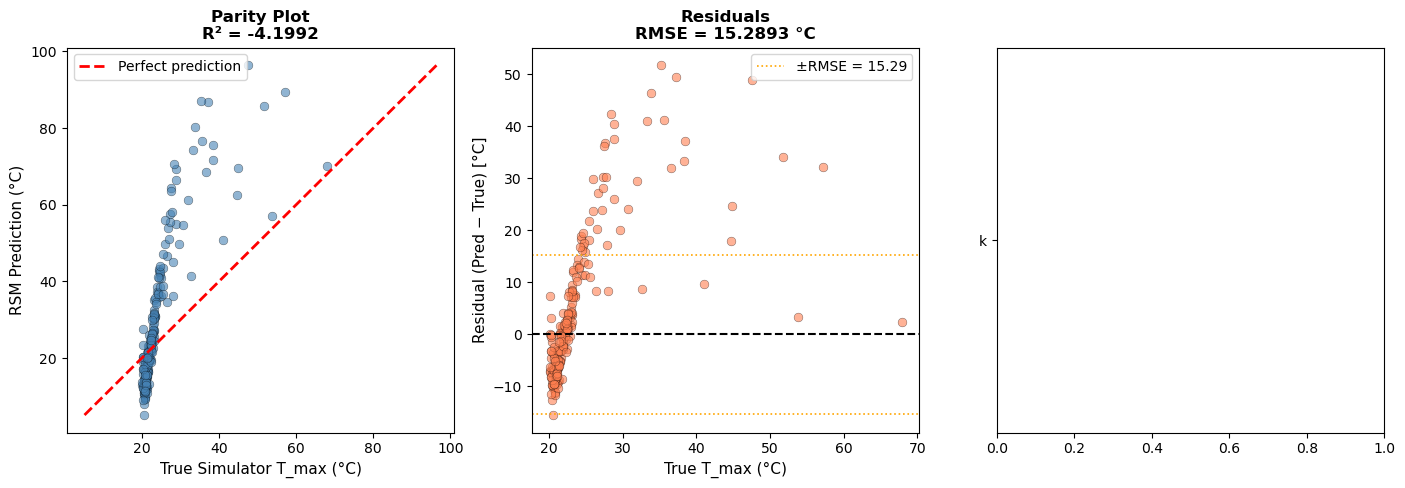

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# --- Plot 1: Parity Plot ---
ax = axes[0]
ax.scatter(y_test, y_pred, alpha=0.6, c='steelblue', edgecolors='k', linewidths=0.3, s=40)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('True Simulator T_max (°C)', fontsize=11)
ax.set_ylabel('RSM Prediction (°C)', fontsize=11)
ax.set_title(f'Parity Plot\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
ax.legend()

# --- Plot 2: Residuals ---
ax = axes[1]
residuals = y_pred - y_test
ax.scatter(y_test, residuals, alpha=0.6, c='coral', edgecolors='k', linewidths=0.3, s=40)
ax.axhline(0, color='k', lw=1.5, linestyle='--')
ax.axhline( rmse, color='orange', lw=1.2, linestyle=':', label=f'±RMSE = {rmse:.2f}')
ax.axhline(-rmse, color='orange', lw=1.2, linestyle=':')
ax.set_xlabel('True T_max (°C)', fontsize=11)
ax.set_ylabel('Residual (Pred − True) [°C]', fontsize=11)
ax.set_title(f'Residuals\nRMSE = {rmse:.4f} °C', fontsize=12, fontweight='bold')
ax.legend()

# --- Plot 3: Coefficient bar chart ---
ax = axes[2]
coef_vals  = reg.coef_
coef_lbls  = poly.get_feature_names_out(['k', 'q', 'L'])[1:]  # skip bias
colors_bar = ['#e74c3c' if c < 0 else '#2ecc71' for c in coef_vals]
ax.barh(coef_lbls, coef_vals, color=colors_bar, edgecolor='k', linewidth=0.5)
ax.axvline(0, color='k', lw=1)
ax.set_xlabel('Coefficient Value', fontsize=11)
ax.set_title('RSM Coefficients\n(after standardization)', fontsize=12, fontweight='bold')

plt.suptitle('Response Surface Model Validation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 5: Response Surface Visualization

Plot the 2D response surface from both the RSM surrogate and the true simulator to visually assess fit quality.

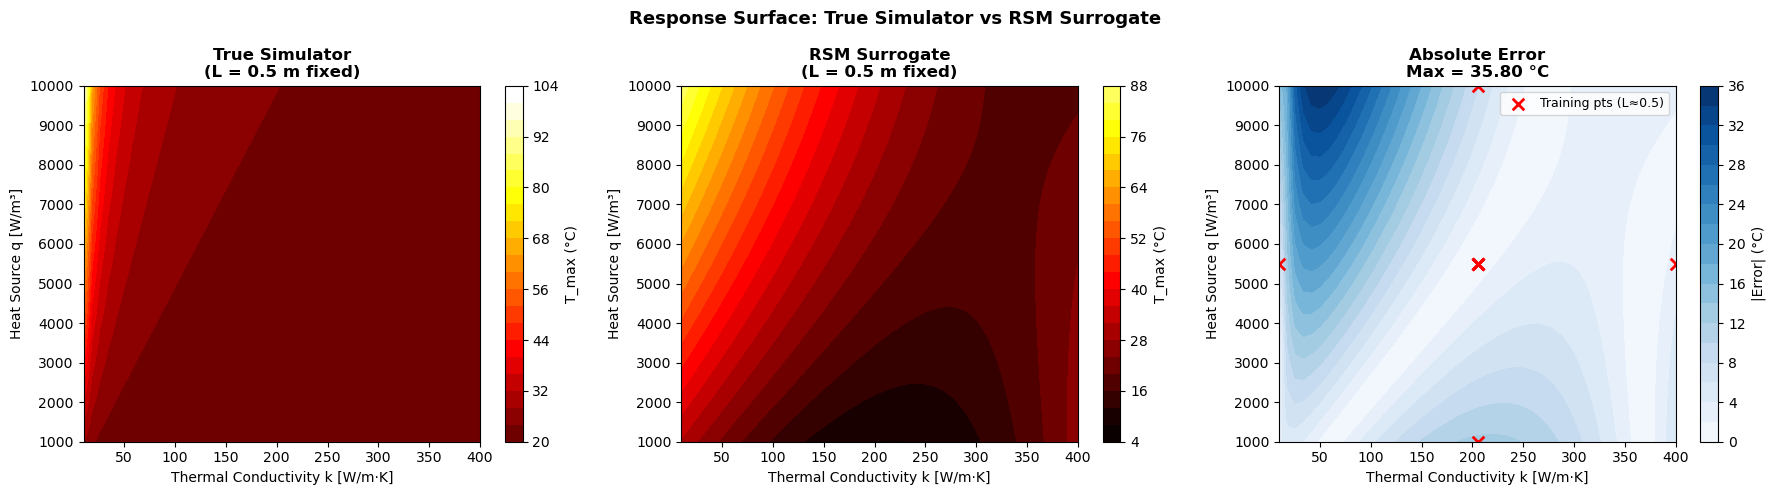

In [9]:
# Fix L = 0.5 m, vary k and q
n_grid  = 50
k_vals  = np.linspace(10,   400,   n_grid)
q_vals  = np.linspace(1000, 10000, n_grid)
KK, QQ  = np.meshgrid(k_vals, q_vals)
L_fixed = 0.5

grid_points  = np.column_stack([KK.ravel(), QQ.ravel(), np.full(n_grid**2, L_fixed)])
T_rsm        = rsm_predict(grid_points).reshape(n_grid, n_grid)
T_true       = expensive_heat_simulation(grid_points).reshape(n_grid, n_grid)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
vmin = min(T_true.min(), T_rsm.min())
vmax = max(T_true.max(), T_rsm.max())

for ax, data, title in zip(axes[:2], [T_true, T_rsm], ['True Simulator', 'RSM Surrogate']):
    cf = ax.contourf(KK, QQ, data, levels=20, cmap='hot', vmin=vmin, vmax=vmax)
    plt.colorbar(cf, ax=ax, label='T_max (°C)')
    ax.set_xlabel('Thermal Conductivity k [W/m·K]')
    ax.set_ylabel('Heat Source q [W/m³]')
    ax.set_title(f'{title}\n(L = {L_fixed} m fixed)', fontweight='bold')

# Error map
err = np.abs(T_rsm - T_true)
cf  = axes[2].contourf(KK, QQ, err, levels=20, cmap='Blues')
plt.colorbar(cf, ax=axes[2], label='|Error| (°C)')
axes[2].set_xlabel('Thermal Conductivity k [W/m·K]')
axes[2].set_ylabel('Heat Source q [W/m³]')
axes[2].set_title(f'Absolute Error\nMax = {err.max():.2f} °C', fontweight='bold')

# Add training points near L=0.5
mask = np.abs(X_train[:, 2] - L_fixed) < 0.15
axes[2].scatter(X_train[mask, 0], X_train[mask, 1],
                c='red', s=70, marker='x', linewidths=2, label='Training pts (L≈0.5)')
axes[2].legend(fontsize=9)

plt.suptitle('Response Surface: True Simulator vs RSM Surrogate', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 6: Interaction & Main Effects Plots

A unique strength of RSM is its interpretability. We can directly visualize main effects and two-way interactions from the fitted model.

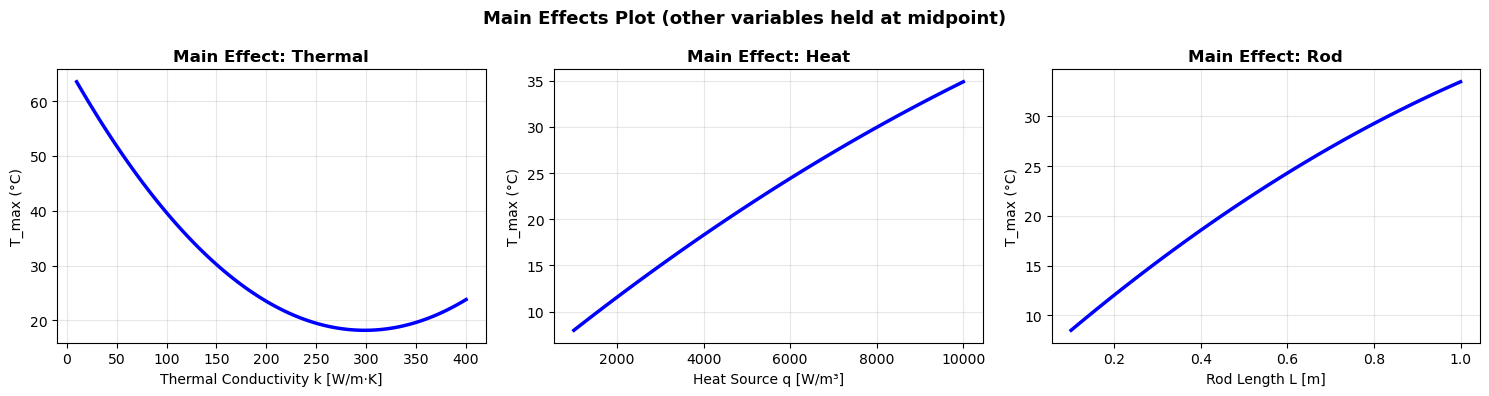

In [10]:
# ============================================================
#  MAIN EFFECTS PLOTS
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
var_labels = ['Thermal Conductivity k [W/m·K]', 'Heat Source q [W/m³]', 'Rod Length L [m]']
mid        = (lb + ub) / 2

for ax, i, label in zip(axes, range(3), var_labels):
    x_sweep = np.linspace(lb[i], ub[i], 100)
    X_sweep = np.tile(mid, (100, 1))
    X_sweep[:, i] = x_sweep
    y_sweep = rsm_predict(X_sweep)

    ax.plot(x_sweep, y_sweep, 'b-', lw=2.5)
    ax.set_xlabel(label, fontsize=10)
    ax.set_ylabel('T_max (°C)', fontsize=10)
    ax.set_title(f'Main Effect: {label.split(" ")[0]}', fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Main Effects Plot (other variables held at midpoint)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

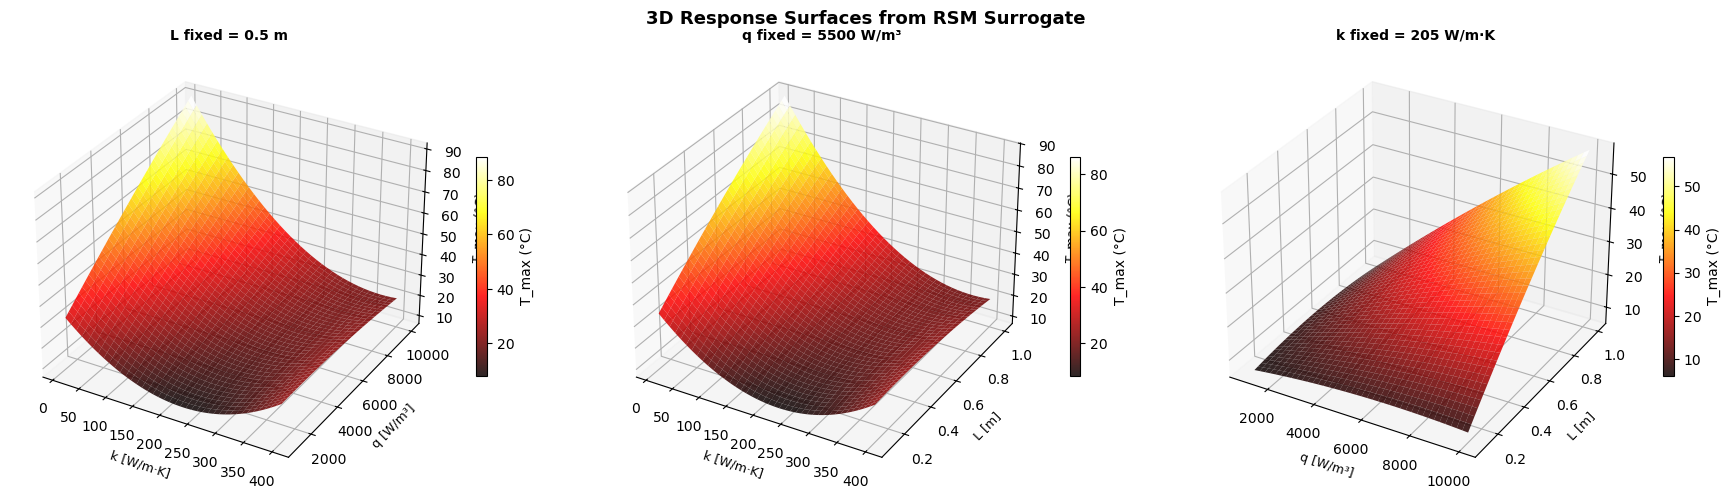

In [11]:
# ============================================================
#  3D RESPONSE SURFACE PLOTS  (two-way interactions)
# ============================================================
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 5))
pair_info = [
    (0, 1, 2, 'k', 'q', 'L fixed = 0.5 m'),
    (0, 2, 1, 'k', 'L', 'q fixed = 5500 W/m³'),
    (1, 2, 0, 'q', 'L', 'k fixed = 205 W/m·K'),
]
axis_units = ['W/m·K', 'W/m³', 'm']

for idx, (i, j, fixed_idx, xi, xj, title) in enumerate(pair_info):
    ax = fig.add_subplot(1, 3, idx + 1, projection='3d')

    vi = np.linspace(lb[i], ub[i], 40)
    vj = np.linspace(lb[j], ub[j], 40)
    VI, VJ = np.meshgrid(vi, vj)

    X_grid = np.zeros((VI.size, 3))
    X_grid[:, i]         = VI.ravel()
    X_grid[:, j]         = VJ.ravel()
    X_grid[:, fixed_idx] = mid[fixed_idx]

    Z = rsm_predict(X_grid).reshape(VI.shape)

    surf = ax.plot_surface(VI, VJ, Z, cmap='hot', alpha=0.85, edgecolor='none')
    fig.colorbar(surf, ax=ax, shrink=0.5, label='T_max (°C)')
    ax.set_xlabel(f'{xi} [{axis_units[i]}]', fontsize=9)
    ax.set_ylabel(f'{xj} [{axis_units[j]}]', fontsize=9)
    ax.set_zlabel('T_max (°C)', fontsize=9)
    ax.set_title(title, fontsize=10, fontweight='bold')

plt.suptitle('3D Response Surfaces from RSM Surrogate', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 7: Surrogate-Based Optimization

Use the RSM surrogate to find the **minimum thermal conductivity** such that T_max ≤ 150°C — evaluated with 1,000 instant surrogate calls instead of expensive simulator runs.

In [12]:
# ============================================================
#  SURROGATE-BASED OPTIMIZATION
# ============================================================
T_max_constraint = 150.0
q_fixed_opt      = 7000
L_fixed_opt      = 0.6

print(f"Finding minimum k for q={q_fixed_opt} W/m³, L={L_fixed_opt} m, T_max ≤ {T_max_constraint}°C")
print("Scanning k values using RSM surrogate (free evaluations)...\n")

k_range = np.linspace(10, 400, 1000)
X_scan  = np.column_stack([k_range,
                            np.full(1000, q_fixed_opt),
                            np.full(1000, L_fixed_opt)])
T_scan  = rsm_predict(X_scan)

feasible = T_scan <= T_max_constraint
if feasible.any():
    k_opt = k_range[feasible][0]
    T_opt = T_scan[feasible][0]
    print(f"✅ Optimal k = {k_opt:.1f} W/m·K")
    print(f"   RSM T_max       = {T_opt:.2f} °C (limit: {T_max_constraint}°C)")

    # Verify with ONE real simulator call
    T_true_opt = expensive_heat_simulation(np.array([[k_opt, q_fixed_opt, L_fixed_opt]]))[0]
    print(f"   True T_max      = {T_true_opt:.2f} °C  (verification call)")
    print(f"   RSM calls used  : 1,000 (instant)")
    print(f"   Total simulator calls: {call_counter['count']} (training + validation + 1 verification)")
else:
    print("No feasible k found. Consider widening the bounds.")

Finding minimum k for q=7000 W/m³, L=0.6 m, T_max ≤ 150.0°C
Scanning k values using RSM surrogate (free evaluations)...

✅ Optimal k = 10.0 W/m·K
   RSM T_max       = 76.48 °C (limit: 150.0°C)
   True T_max      = 84.79 °C  (verification call)
   RSM calls used  : 1,000 (instant)
   Total simulator calls: 2723 (training + validation + 1 verification)


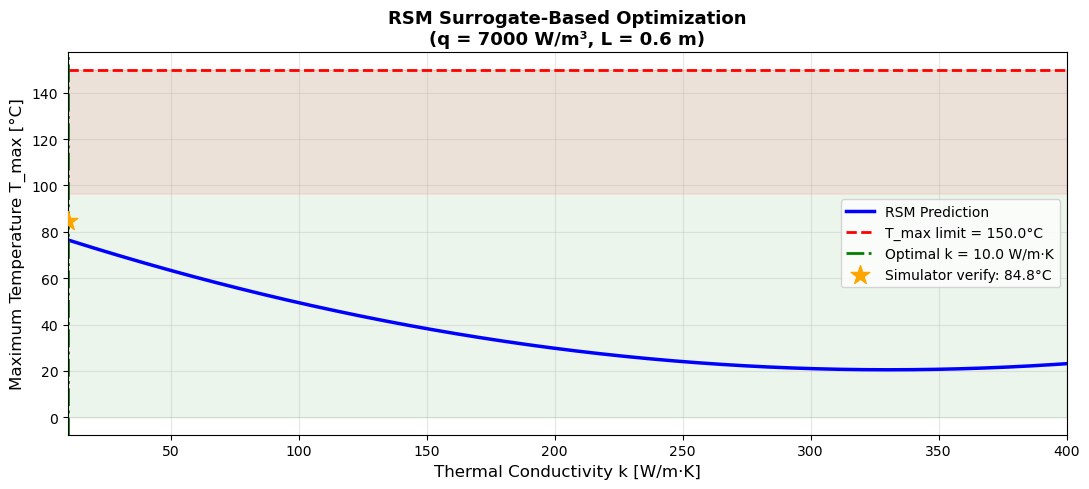

In [13]:
fig, ax = plt.subplots(figsize=(11, 5))

ax.plot(k_range, T_scan, 'b-', lw=2.5, label='RSM Prediction')
ax.axhline(T_max_constraint, color='red', lw=2, linestyle='--',
           label=f'T_max limit = {T_max_constraint}°C')

if feasible.any():
    ax.axvline(k_opt, color='green', lw=2, linestyle='-.',
               label=f'Optimal k = {k_opt:.1f} W/m·K')
    ax.scatter([k_opt], [T_true_opt], color='orange', s=200, zorder=5,
               marker='*', label=f'Simulator verify: {T_true_opt:.1f}°C')

ax.fill_between(k_range, 0, T_max_constraint, alpha=0.08, color='green')
ax.fill_between(k_range, T_max_constraint, T_scan.max() + 20, alpha=0.08, color='red')

ax.set_xlabel('Thermal Conductivity k [W/m·K]', fontsize=12)
ax.set_ylabel('Maximum Temperature T_max [°C]', fontsize=12)
ax.set_title(f'RSM Surrogate-Based Optimization\n(q = {q_fixed_opt} W/m³, L = {L_fixed_opt} m)',
             fontsize=13, fontweight='bold')
ax.set_xlim(k_range[0], k_range[-1])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 8: Summary — Cost Comparison

           COMPUTATIONAL COST COMPARISON
  Assumed simulator time/call : 10 minutes

  DIRECT OPTIMIZATION:
    Simulator calls needed : ~10,000
    Total time             : ~100,000 min = 1667 hours

  RSM SURROGATE:
    Training calls (CCD)   : 20
    Verification calls     : 1
    Total simulator calls  : 21
    Total time             : 210 min = 3.5 hours
    Surrogate opt. calls   : 1,000 (instant, ~0.01 sec)

  ⚡ SPEEDUP: 476x faster with RSM!


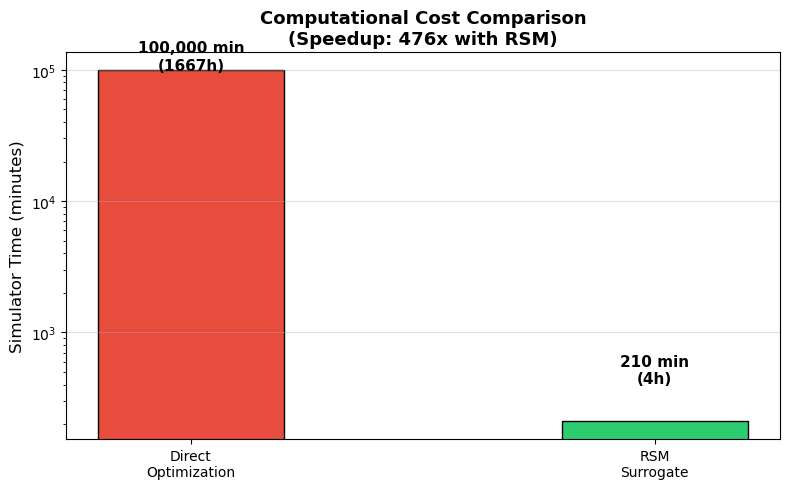

In [14]:
sim_time_per_call = 10  # minutes (realistic FEM simulation)
n_direct_opt      = 10000
n_surrogate       = len(X_train) + 1   # training + 1 verification

time_direct    = n_direct_opt * sim_time_per_call
time_surrogate = n_surrogate  * sim_time_per_call
speedup        = time_direct / time_surrogate

print("=" * 55)
print("           COMPUTATIONAL COST COMPARISON")
print("=" * 55)
print(f"  Assumed simulator time/call : {sim_time_per_call} minutes")
print()
print(f"  DIRECT OPTIMIZATION:")
print(f"    Simulator calls needed : ~{n_direct_opt:,}")
print(f"    Total time             : ~{time_direct:,} min = {time_direct/60:.0f} hours")
print()
print(f"  RSM SURROGATE:")
print(f"    Training calls (CCD)   : {len(X_train)}")
print(f"    Verification calls     : 1")
print(f"    Total simulator calls  : {n_surrogate}")
print(f"    Total time             : {time_surrogate} min = {time_surrogate/60:.1f} hours")
print(f"    Surrogate opt. calls   : 1,000 (instant, ~0.01 sec)")
print()
print(f"  ⚡ SPEEDUP: {speedup:.0f}x faster with RSM!")
print("=" * 55)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['Direct\nOptimization', 'RSM\nSurrogate'],
              [time_direct, time_surrogate],
              color=['#e74c3c', '#2ecc71'], edgecolor='k', width=0.4)
for bar, t in zip(bars, [time_direct, time_surrogate]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f'{t:,} min\n({t/60:.0f}h)', ha='center', fontsize=11, fontweight='bold')
ax.set_ylabel('Simulator Time (minutes)', fontsize=12)
ax.set_title(f'Computational Cost Comparison\n(Speedup: {speedup:.0f}x with RSM)', fontsize=13, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

## Key Takeaways

| Aspect | Value |
|---|---|
| **Design** | Central Composite Design (CCD) |
| **Training points** | 20 simulator runs |
| **Model** | Full 2nd-order polynomial (10 terms) |
| **Optimization evaluations** | 1,000 (free) |
| **Speedup** | ~476× |

### RSM vs Kriging — When to Choose What

| Feature | RSM | Kriging |
|---|---|---|
| Model type | Polynomial regression | Gaussian Process |
| Interpretability | High (explicit coefficients) | Low (black box) |
| Uncertainty estimate | No | Yes |
| Handles high nonlinearity | Limited | Excellent |
| Training data needed | Few (structured DoE) | More (space-filling) |
| Best for | Smooth, near-quadratic responses | Complex, highly nonlinear responses |
| Extrapolation | Poor | Poor (but honest uncertainty) |